# Majority vote classifier

## Setting up
- Iris data
- Binary classification
- 2 features

In [36]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Iris data
dataObj = load_iris()

# X data
X = dataObj.data[50:, [1, 2]]

# y data. We will use only two classes (for ROC AUC calculation).
y = dataObj.target[50:]

# Set the class label to 0 and 1
y = np.where(y == 2, 1, 0)
print(np.unique(y))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

[0 1]


## Training performance of individual classifiers

In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import make_scorer

In [38]:
#Logistic regression
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
pipe_lr = Pipeline([['sc', StandardScaler()], ['clf', clf1]])

# Decision tree
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
pipe_dt = Pipeline([['sc', StandardScaler()], ['clf', clf2]])

# KNN
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe_knn = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

pipes = [pipe_lr, pipe_dt, pipe_knn]
names = ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbor']

In [39]:
# Make scorer
scorer_ACC = make_scorer(accuracy_score)
scorer_PRE = make_scorer(precision_score, zero_division=0, pos_label=1)
scorer_REC = make_scorer(recall_score, zero_division=0, pos_label=1)
scorer_F1 = make_scorer(f1_score, pos_label=1)
scorer_ROCAUC = make_scorer(roc_auc_score)

scorings = {'accuracy':scorer_ACC,
            'precision':scorer_PRE,
            'recall': scorer_REC,
            'f1': scorer_F1,
            'rocauc': scorer_ROCAUC}

In [40]:
# Empty dataframe
df1 = pd.DataFrame()

# Main calculations
for pipe, name in zip(pipes, names):
        sc = cross_validate(estimator=pipe,
                                X=X_train,
                                y=y_train,
                                cv=10,
                                scoring=scorings,
                                n_jobs=-1)
                                
        ACC = sc['test_accuracy']
        PRE = sc['test_precision']
        REC = sc['test_recall']
        F1 = sc['test_f1']
        ROCAUC = sc['test_rocauc']

        data = {'clf': name,
                'ACC': f"{ACC.mean():6.3f} (+/- {ACC.std():6.3f})",
                'PRE': f"{PRE.mean():6.3f} (+/- {PRE.std():6.3f})",
                'REC': f"{REC.mean():6.3f} (+/- {REC.std():6.3f})",
                'F1': f"{F1.mean():6.3f} (+/- {F1.std():6.3f})",
                'ROCAUC': f"{ROCAUC.mean():6.3f} +/- {ROCAUC.std():6.3f}"}

        df1 = df1.append(data, ignore_index=True)
        
df1 = df1[['clf', 'ACC', 'PRE', 'REC', 'F1', 'ROCAUC']]
df1 = df1.set_index(["clf"])
display(df1)

,ACC,PRE,REC,F1,ROCAUC
clf,,,,,
Logistic Regression,0.440 (+/- 0.080),0.400 (+/- 0.346),0.567 (+/- 0.448),0.386 (+/- 0.254),0.533 +/- 0.067
Decision Tree,0.860 (+/- 0.201),0.792 (+/- 0.315),0.850 (+/- 0.320),0.816 (+/- 0.312),0.867 +/- 0.183
K-Nearest Neighbor,0.840 (+/- 0.150),0.892 (+/- 0.175),0.850 (+/- 0.241),0.829 (+/- 0.167),0.850 +/- 0.133


## Training performance of majority vote classifier

In [41]:
from sklearn.ensemble import VotingClassifier

# Ensemble estimator
estimators = [
    ('pipe_lr', pipe_lr),
    ('pipe_dt', pipe_dt),
    ('pipe_knn', pipe_knn)]
    
eclf = VotingClassifier(estimators=estimators, voting='soft')



sc = cross_validate(estimator=eclf,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        scoring=scorings,
                        n_jobs=-1)
                        
ACC = sc['test_accuracy']
PRE = sc['test_precision']
REC = sc['test_recall']
F1 = sc['test_f1']
ROCAUC = sc['test_rocauc']


data = {'clf': 'Ensemble',
        'ACC': f"{ACC.mean():6.3f} (+/- {ACC.std():6.3f})",
        'PRE': f"{PRE.mean():6.3f} (+/- {PRE.std():6.3f})",
        'REC': f"{REC.mean():6.3f} (+/- {REC.std():6.3f})",
        'F1': f"{F1.mean():6.3f} (+/- {F1.std():6.3f})",
        'ROCAUC': f"{ROCAUC.mean():6.3f} +/- {ROCAUC.std():6.3f}"}
df2 = pd.DataFrame()
df2 = df2.append(data, ignore_index=True)
df2 = df2.set_index(["clf"])

df = pd.concat((df1,df2))
display(df)

,ACC,PRE,REC,F1,ROCAUC
clf,,,,,
Logistic Regression,0.440 (+/- 0.080),0.400 (+/- 0.346),0.567 (+/- 0.448),0.386 (+/- 0.254),0.533 +/- 0.067
Decision Tree,0.860 (+/- 0.201),0.792 (+/- 0.315),0.850 (+/- 0.320),0.816 (+/- 0.312),0.867 +/- 0.183
K-Nearest Neighbor,0.840 (+/- 0.150),0.892 (+/- 0.175),0.850 (+/- 0.241),0.829 (+/- 0.167),0.850 +/- 0.133
Ensemble,0.860 (+/- 0.156),0.917 (+/- 0.171),0.850 (+/- 0.241),0.843 (+/- 0.175),0.875 +/- 0.136


## Making prediction

In [42]:
# Make prediction
eclf.fit(X_train, y_train)
print(eclf.predict(X_test))

[0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0
 1 0 0 1 1 0 1 0 0 1 0 0 0]


## Testing performances

In [43]:
pipes = [pipe_lr, pipe_dt, pipe_knn, eclf]
names = ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbor', 'Ensemble']

df = pd.DataFrame()

for pipe, name in zip(pipes, names):

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)

    ACC = accuracy_score(y_true=y_test, y_pred=y_pred)
    PRE = precision_score(y_true=y_test, y_pred=y_pred, pos_label=1)
    REC = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1)
    F1 = f1_score(y_true=y_test, y_pred=y_pred, pos_label=1)
    ROCAUC = roc_auc_score(y_true=y_test, y_score=y_proba[:,1])

    data = {'clf': name, 'ACC': ACC, 'PRE': PRE, 'REC': REC, 'F1': F1, 'ROCAUC': ROCAUC}

    df = df.append(data, ignore_index=True)

df = df[['clf', 'ACC', 'PRE', 'REC', 'F1', 'ROCAUC']]
df = df.set_index(['clf'])
display(df)


,ACC,PRE,REC,F1,ROCAUC
clf,,,,,
Logistic Regression,0.84,0.840000,0.84,0.840000,0.9536
Decision Tree,0.90,0.954545,0.84,0.893617,0.9000
K-Nearest Neighbor,0.86,0.909091,0.80,0.851064,0.8600
Ensemble,0.86,0.909091,0.80,0.851064,0.9488


### About AUC - ROC curve
- AUC (Area Under The Curve) ROC (Receiver Operating Characteristics)
- Performance measurement for the classification problems at various threshold settings.
- ROC is a probability curve and AUC represents the degree or measure of separability. 
- Tells how much the model is capable of distinguishing between classes.
- The higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

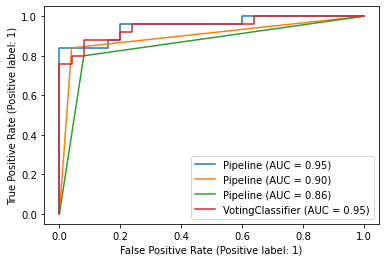

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve

ax = plt.gca()
for pipe in pipes:
    plot_roc_curve(pipe, X_test,y_test, ax=ax)

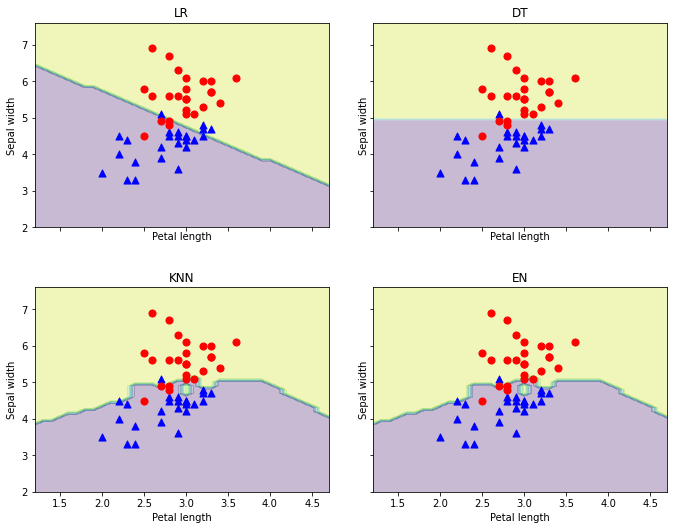

In [45]:
from itertools import product

all_clf = [pipe_lr, pipe_dt, pipe_knn, eclf]
clf_labels = ["LR", "DT", "KNN", "EN"]

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):

    clf.fit(X_train, y_train)    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_test[y_test==0, 0], 
                                  X_test[y_test==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_test[y_test==1, 0], 
                                  X_test[y_test==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)
    axarr[idx[0], idx[1]].set_xlabel("Petal length")
    axarr[idx[0], idx[1]].set_ylabel("Sepal width")

plt.tight_layout(pad=3.0)
plt.show()

## Tuning parameter using grid search

In [46]:
# Get parameter names
for k, v in eclf.get_params().items():
    print(f"{k:35.35s}: {str(v):35.35}...")

estimators                         : [('pipe_lr', Pipeline(steps=[('sc',...
flatten_transform                  : True                               ...
n_jobs                             : None                               ...
verbose                            : False                              ...
voting                             : soft                               ...
weights                            : None                               ...
pipe_lr                            : Pipeline(steps=[('sc', StandardScal...
pipe_dt                            : Pipeline(steps=[('sc', StandardScal...
pipe_knn                           : Pipeline(steps=[('sc', StandardScal...
pipe_lr__memory                    : None                               ...
pipe_lr__steps                     : [('sc', StandardScaler()), ['clf', ...
pipe_lr__verbose                   : False                              ...
pipe_lr__sc                        : StandardScaler()                   ...
pipe_lr__clf

In [47]:
from sklearn.model_selection import GridSearchCV

# Parameters
params = {'pipe_dt__clf__max_depth': [1, 2], 'pipe_lr__clf__C': [0.001, 0.01, 0.1]}

# Grid search using ROC AUC as a score
gs = GridSearchCV(estimator=eclf, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)

# Searching
gs.fit(X_train, y_train)

# Best estimator
gs.best_estimator_

VotingClassifier(estimators=[('pipe_lr',
                              Pipeline(steps=[('sc', StandardScaler()),
                                              ['clf',
                                               LogisticRegression(C=0.1,
                                                                  random_state=0)]])),
                             ('pipe_dt',
                              Pipeline(steps=[('sc', StandardScaler()),
                                              ['clf',
                                               DecisionTreeClassifier(criterion='entropy',
                                                                      max_depth=1,
                                                                      random_state=0)]])),
                             ('pipe_knn',
                              Pipeline(steps=[('sc', StandardScaler()),
                                              ['clf',
                                               KNeighborsClassifier(n_nei

In [48]:
df = pd.DataFrame(gs.cv_results_)
display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pipe_dt__clf__max_depth,param_pipe_lr__clf__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007298,0.001117,0.001148,4.937563e-04,1,0.001,"{'pipe_dt__clf__max_depth': 1, 'pipe_lr__clf__...",1.0,1.0,0.8,0.8,0.6,1.0,0.6,1.0,0.8,1.0,0.86,0.156205,4
1,0.007646,0.000762,0.001056,1.681977e-04,1,0.01,"{'pipe_dt__clf__max_depth': 1, 'pipe_lr__clf__...",1.0,1.0,0.8,0.8,0.6,1.0,0.6,1.0,0.8,1.0,0.86,0.156205,4
2,0.007302,0.000458,0.001000,1.668930e-07,1,0.1,"{'pipe_dt__clf__max_depth': 1, 'pipe_lr__clf__...",1.0,1.0,0.8,0.8,0.6,1.0,0.6,1.0,1.0,1.0,0.88,0.160000,1
3,0.007302,0.000640,0.001400,4.900085e-04,2,0.001,"{'pipe_dt__clf__max_depth': 2, 'pipe_lr__clf__...",1.0,1.0,0.8,1.0,0.6,1.0,0.4,1.0,0.8,1.0,0.86,0.200998,6
4,0.007902,0.002120,0.001600,6.633560e-04,2,0.01,"{'pipe_dt__clf__max_depth': 2, 'pipe_lr__clf__...",1.0,1.0,0.8,1.0,0.6,1.0,0.4,1.0,1.0,1.0,0.88,0.203961,1
5,0.007602,0.000917,0.001200,6.002984e-04,2,0.1,"{'pipe_dt__clf__max_depth': 2, 'pipe_lr__clf__...",1.0,1.0,0.8,1.0,0.6,1.0,0.4,1.0,1.0,1.0,0.88,0.203961,1
